# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

## Project Statement

In this capstone project, We need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library.

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

The project is an extended application of [Show, Attend and Tell: Neural Image Caption Generation](https://arxiv.org/abs/1502.03044) with Visual Attention paper.

## Architecture


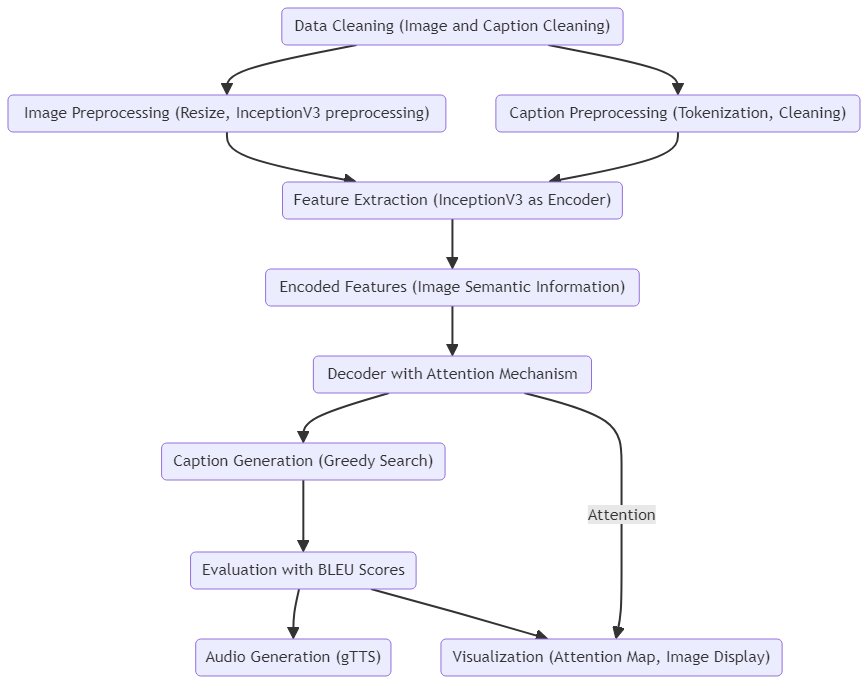

As high level illustration using the graph flow diagram above, the following are the architecure components used in the project:



1. **Data Understanding & Cleaning:** Prepares and cleans the image and caption data before preprocessing.

2. **Image Preprocessing:** Handles the image-related preprocessing before passing it to the feature extraction layer.

3. **Caption Preprocessing:** Prepares and tokenizes the captions for input to the decoder.
at the high level

4. **Image Preprocessing Layer:** Image loading, resizing, and preprocessing for InceptionV3.

5. **Feature Extraction (Encoder):** InceptionV3 as a feature extractor, with reshaped features fed into the encoder.

6. **Decoder with Attention Mechanism:** Decoder uses attention to generate captions based on encoded features.

7. **Caption Generation:** Greedy search for the next word, until the caption is complete.

8. **Evaluation with BLEU Scores:** Comparison of generated captions with ground truth.

9. **Audio Generation:** Generated caption converted to speech using gTTS.

10. **Visualization:** Image and attention map visualization.


## Setup Required Modules

### Install required modules

In [4]:
!pip install gtts

In [5]:
!pip install tensorflow

In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb 19 10:57:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   33C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Import Required Modules

In [157]:
#Import all the required libraries
import os
import glob
import time
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from tqdm import tqdm
import csv # to import the csv module

import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from gtts import gTTS # to import googles text to speech

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import layers, Model

from IPython.display import display, Audio, Image


In [91]:
from tensorflow.keras.saving import register_keras_serializable

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [10]:
#Import the dataset and read the image into a seperate variable

images="/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images"

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [11]:
#Import the dataset and read the text file into a seperate variable
def load_doc(filename):
  # Open and read the text file containing captions
  with open(filename, 'r') as file:
      text = file.read()
  return text

text_file = '/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/captions.txt'  # Adjust this path to your captions file
doc = load_doc(text_file)
print(doc[:300])  # Print first 300 characters of the document for preview

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


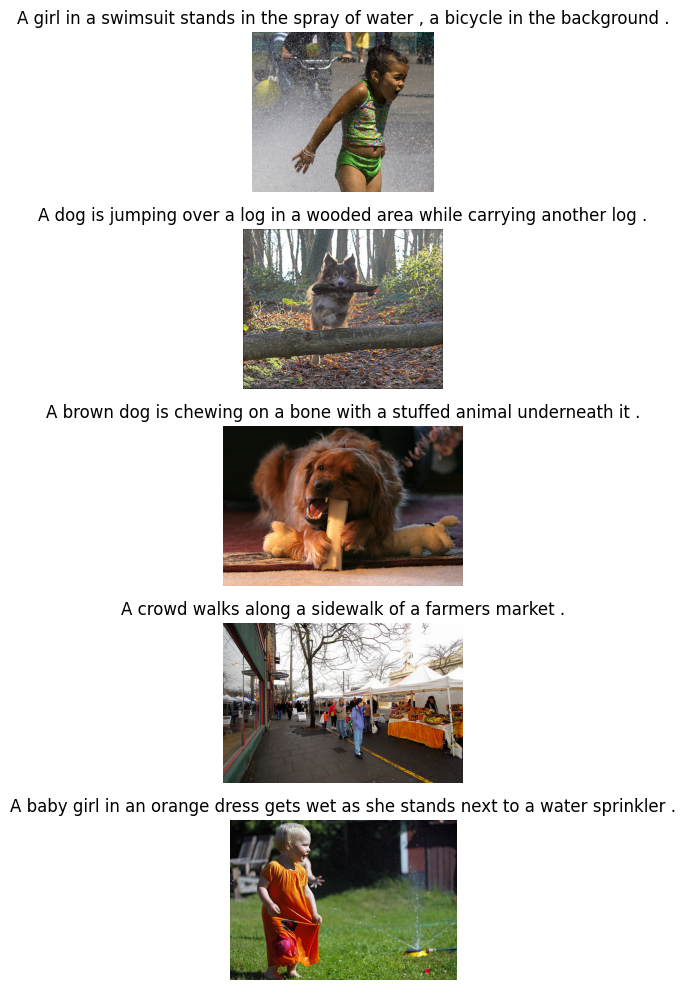

In [12]:
# Now visualize the first 5 images and their corresponding first caption from the captions file

# Lets get a dictionary to store the first caption for each image
image_captions = {}

# Load captions from doc
reader = csv.reader(doc.splitlines(), delimiter=',')
for row in reader:
    image_id, caption = row[0].strip(), row[1].strip()
    if image_id not in image_captions: # we only need the first caption
        image_captions[image_id] = caption

plt.figure(figsize=(15, 10))

# Loop through the first 5 images and get their first caption
for i in range(5):
    # Get the image path and filename
    img_path = all_imgs[i]
    img_name = img_path.split('/')[-1]

    # Get the first caption for this image
    caption = image_captions.get(img_name, "No caption available")

    # Load and display the image
    img = Image.open(img_path)

    # Plot the image
    plt.subplot(5, 1, i + 1)
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


**note:** We can see that some of the 5 images shown above are of different dimensions

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [13]:
all_imgs[:5]

['/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/3765374230_cb1bbee0cb.jpg',
 '/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/378453580_21d688748e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/381275595_b429fd1639.jpg',
 '/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/380515798_c2abbf46b0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/3767841911_6678052eb6.jpg']

In [14]:
print(doc[:100])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an


the doc variable contains a header followed by <image_name, caption> csv format


In [15]:
all_img_id = []#store all the image id here
all_img_vector = [] #store all the image path here
annotations = [] #store all the captions here

# We have already loaded the caption file into doc variable so,
# Parse the caption file and store captions, image ids, and image paths
df_captions = pd.read_csv(text_file)

# Skip the header line (handled by pandas) and process the data
for _, row in df_captions.iterrows():
    image_id = row['image']  # Extract the image filename
    caption = row['caption']  # Extract the caption

    # Store the image ID, image path, and caption
    all_img_id.append(image_id)
    all_img_vector.append(images + '/' + image_id)  # Assuming 'images' is the folder containing images
    annotations.append(caption)

df = pd.DataFrame(list(zip(all_img_id, all_img_vector, annotations)),columns =['ID','Path', 'Captions'])

print(df.head())

                          ID  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                Path  \
0  /content/drive/MyDrive/Colab Notebooks/01. Ass...   
1  /content/drive/MyDrive/Colab Notebooks/01. Ass...   
2  /content/drive/MyDrive/Colab Notebooks/01. Ass...   
3  /content/drive/MyDrive/Colab Notebooks/01. Ass...   
4  /content/drive/MyDrive/Colab Notebooks/01. Ass...   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [17]:
row = df.iloc[0]
for column in df.columns:
    print(f"{column}: {row[column]}")

ID: 1000268201_693b08cb0e.jpg
Path: /content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/1000268201_693b08cb0e.jpg
Captions: A child in a pink dress is climbing up a set of stairs in an entry way .


In [18]:
annotations[0:5]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [19]:
annotations[0:5]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [20]:
#Create a list which contains all the captions
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=all_img_vector

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


### Data Cleaning
* Convert all words to lowercase
* Remove punctuations
* Remove punctuation & numbers, keep <start> and <end>
* Remove single-character words. Helps in reducing noise (except for "a" if it's part of <start> or <end> tokens). The articles "a", "an" or "the" provide context for language generation.
Example: Removing words like "s" or "x" that don’t contribute meaningfully.
* We are not doing stemming, since Stemming (running -> run)can distort words. Since Captions are natural resources, keeping words as they are is better.

**Impact of Data Cleaning:**

✔ Better word embeddings: No duplicate embeddings (e.g., "Cat" vs. "cat").

✔ Improved model training: Less noise in data, better generalization.

✔ Reduced vocabulary size: Helps in efficient training & better word alignment.

✔ Preserves sentence structure: Makes captions still understandable for RNN-based models.

In [21]:
annotations[0:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [22]:
import re

def clean_caption(caption):
    caption = caption.lower()  # Convert to lowercase
    caption = re.sub(r"[^a-z\s<>]", "", caption)  # Remove punctuation & numbers, keep <start> and <end>
    caption = " ".join([word for word in caption.split() if len(word) > 1 or word in ["a", "<start>", "<end>"]])  # Remove single-letter words except article "a"
    return caption

annotations = [clean_caption(c) for c in annotations]

annotations[0:5]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
 '<start> a girl going into a wooden building <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a little girl climbing the stairs to her playhouse <end>',
 '<start> a little girl in a pink dress going into a wooden cabin <end>']

In [23]:
#Create the vocabulary & the counter for the captions

from collections import Counter
import re

# Tokenize and create vocabulary
def tokenize(caption):
  # Remove <start> and <end> tags
  caption = caption.replace('<start>', '').replace('<end>', '').strip()
  # Lowercase and remove non-alphabetical characters (simple tokenization)
  caption = caption.lower()
  tokens = re.findall(r'\w+', caption)
  return tokens

all_tokens = []
for caption in annotations:
    tokens = tokenize(caption)
    all_tokens.extend(tokens)

# Count word occurrences
vocabulary = all_tokens
val_count = Counter(vocabulary)

val_count=Counter(vocabulary)
val_count

Counter({'a': 62986,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tricolored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
         'at': 2914,
         'street

In [24]:
val_count.most_common(30)

[('a', 62986),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265),
 ('of', 6713),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3173),
 ('wearing', 3062),
 ('at', 2914),
 ('people', 2883),
 ('water', 2783),
 ('red', 2672),
 ('young', 2630),
 ('brown', 2563),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2268),
 ('dogs', 2125),
 ('running', 2073)]

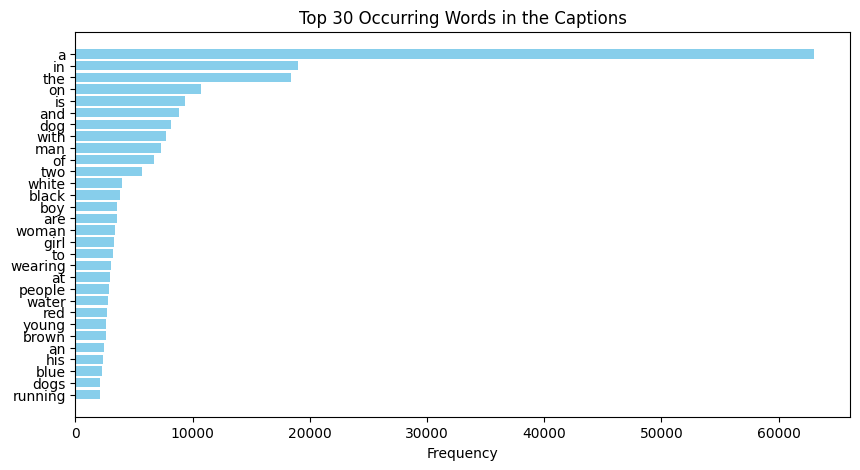

In [25]:
#Visualise the top 30 occuring words in the captions
# Visualize the top 30 occurring words in the captions
top_words = val_count.most_common(30)
words, counts = zip(*top_words)

plt.figure(figsize=(10, 5))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 30 Occurring Words in the Captions')
plt.gca().invert_yaxis()  # Invert y-axis to display top words on top
plt.show()


#write your code here

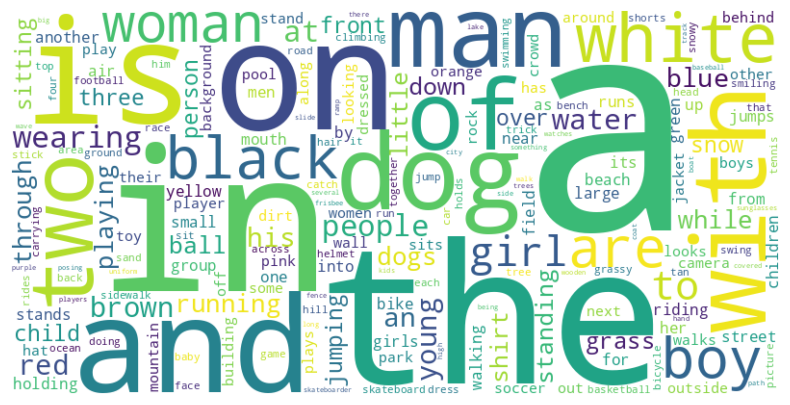

In [26]:
# Generate word cloud
def plot_wordcloud(vocabulary):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocabulary)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Plot the word cloud for the vocabulary
plot_wordcloud(val_count)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### Tokenize the Captions

In [27]:
# Create the tokeniser
vocab_size = 5000  # Keeping vocabulary size to top 5000 words
tokenizer = Tokenizer(num_words=vocab_size+1,
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                      lower=True,
                      char_level=False,
                      oov_token="UNK")

tokenizer.fit_on_texts(annotations)  # Fit tokenizer on captions

# Ensure 'PAD' token is set at index 0
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

# Convert text to sequences (numerical encoding)
sequences = tokenizer.texts_to_sequences(annotations)

# Extract word-index mapping
word_index = tokenizer.word_index # word_index → Maps each word to a unique integer index. e.g: {'the': 1, 'a': 2, 'dog': 3, 'is': 4, 'running': 5}

# Now lets reverse map word_index, converting indices back to words
index_word = {index: word for word, index in word_index.items()} # {1: 'the', 2: 'a', 3: 'dog', 4: 'is', 5: 'running'}
# The above steps are essential for decoding tokenized sequences into readable captions.

print("Sample Tokenized Sequences:", sequences[:3])  # Print first 3 tokenized captions


Sample Tokenized Sequences: [[3, 2, 43, 5, 2, 91, 170, 8, 120, 54, 2, 395, 13, 392, 5, 29, 1, 693, 4], [3, 2, 20, 314, 65, 2, 194, 118, 4], [3, 2, 41, 20, 120, 65, 2, 194, 2424, 4]]


In [28]:
list(index_word.items())[0:5]

[(1, 'UNK'), (2, 'a'), (3, '<start>'), (4, '<end>'), (5, 'in')]

In [29]:
annotations[:5]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
 '<start> a girl going into a wooden building <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a little girl climbing the stairs to her playhouse <end>',
 '<start> a little girl in a pink dress going into a wooden cabin <end>']

In [30]:
sequences[:5]

[[3, 2, 43, 5, 2, 91, 170, 8, 120, 54, 2, 395, 13, 392, 5, 29, 1, 693, 4],
 [3, 2, 20, 314, 65, 2, 194, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 194, 2424, 4],
 [3, 2, 41, 20, 120, 6, 392, 21, 61, 2424, 4],
 [3, 2, 41, 20, 5, 2, 91, 170, 314, 65, 2, 194, 2986, 4]]

In [31]:
print(len(sequences))

40455


In [32]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [33]:
tokenizer.index_word

{1: 'UNK',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog',
 11: 'with',
 12: 'man',
 13: 'of',
 14: 'two',
 15: 'white',
 16: 'black',
 17: 'boy',
 18: 'are',
 19: 'woman',
 20: 'girl',
 21: 'to',
 22: 'wearing',
 23: 'at',
 24: 'people',
 25: 'water',
 26: 'red',
 27: 'young',
 28: 'brown',
 29: 'an',
 30: 'his',
 31: 'blue',
 32: 'dogs',
 33: 'running',
 34: 'through',
 35: 'playing',
 36: 'while',
 37: 'down',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'little',
 42: 'grass',
 43: 'child',
 44: 'person',
 45: 'snow',
 46: 'jumping',
 47: 'over',
 48: 'front',
 49: 'three',
 50: 'sitting',
 51: 'holding',
 52: 'field',
 53: 'small',
 54: 'up',
 55: 'by',
 56: 'large',
 57: 'green',
 58: 'group',
 59: 'one',
 60: 'yellow',
 61: 'her',
 62: 'walking',
 63: 'children',
 64: 'men',
 65: 'into',
 66: 'air',
 67: 'beach',
 68: 'near',
 69: 'mouth',
 70: 'jumps',
 71: 'another',
 72: 'for',
 73: 'street',
 74: 'runs',
 75: 'its',
 7

### Replace Rare Words with "UNK"

In [34]:
tokenizer.word_index["UNK"]

1

In [35]:
sequences[:3]

[[3, 2, 43, 5, 2, 91, 170, 8, 120, 54, 2, 395, 13, 392, 5, 29, 1, 693, 4],
 [3, 2, 20, 314, 65, 2, 194, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 194, 2424, 4]]

In [36]:
# Update sequences to replace rare words with "UNK"
for i in range(len(sequences)):
    sequences[i] = [word if word < vocab_size else tokenizer.word_index["UNK"] for word in sequences[i]]

# Print the first 3 tokenized captions after applying "UNK"
print("Updated Tokenized Sequences:")
sequences[:3]


Updated Tokenized Sequences:


[[3, 2, 43, 5, 2, 91, 170, 8, 120, 54, 2, 395, 13, 392, 5, 29, 1, 693, 4],
 [3, 2, 20, 314, 65, 2, 194, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 194, 2424, 4]]

### Create Word-to-Index and Index-to-Word Mappings

In [37]:
# Create word-to-index and index-to-word mappings.

#your code here
# Create word-to-index and index-to-word mappings
word_to_index = tokenizer.word_index
index_to_word = {index: word for word, index in word_to_index.items()}

print("Sample word_to_index:", list(word_to_index.items())[:10])
print("Sample index_to_word:", list(index_to_word.items())[:10])


Sample word_to_index: [('UNK', 1), ('a', 2), ('<start>', 3), ('<end>', 4), ('in', 5), ('the', 6), ('on', 7), ('is', 8), ('and', 9), ('dog', 10)]
Sample index_to_word: [(1, 'UNK'), (2, 'a'), (3, '<start>'), (4, '<end>'), (5, 'in'), (6, 'the'), (7, 'on'), (8, 'is'), (9, 'and'), (10, 'dog')]


### Visualize Top 30 Most Frequent Words

In [38]:
# Flatten the annotations list and count word occurrences
tokenizer_top_words = [word for line in annotations for word in line.split()]
tokenizer_top_words_count = Counter(tokenizer_top_words)

# Get the top 30 most common words
top_30_words = tokenizer_top_words_count.most_common(30)
print(top_30_words)


[('a', 62986), ('<start>', 40455), ('<end>', 40455), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265), ('of', 6713), ('two', 5638), ('white', 3940), ('black', 3832), ('boy', 3581), ('are', 3504), ('woman', 3402), ('girl', 3328), ('to', 3173), ('wearing', 3062), ('at', 2914), ('people', 2883), ('water', 2783), ('red', 2672), ('young', 2630), ('brown', 2563), ('an', 2432), ('his', 2357), ('blue', 2268)]


In [39]:
# Convert to DataFrame for visualization
df_top_words = pd.DataFrame(top_30_words, columns=['Word', 'Count'])

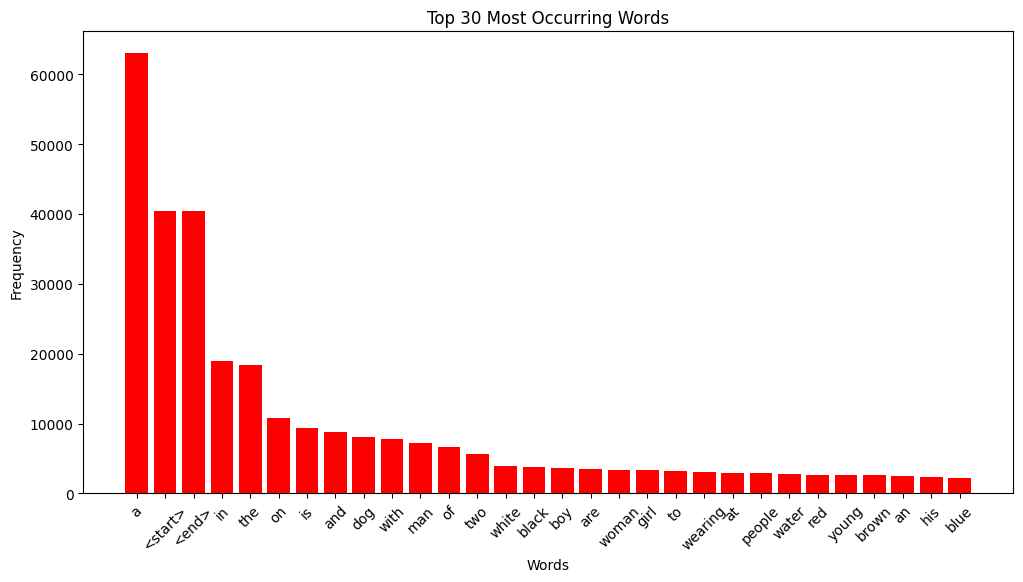

In [40]:
# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_top_words['Word'], df_top_words['Count'], color='red')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 30 Most Occurring Words")
plt.show()

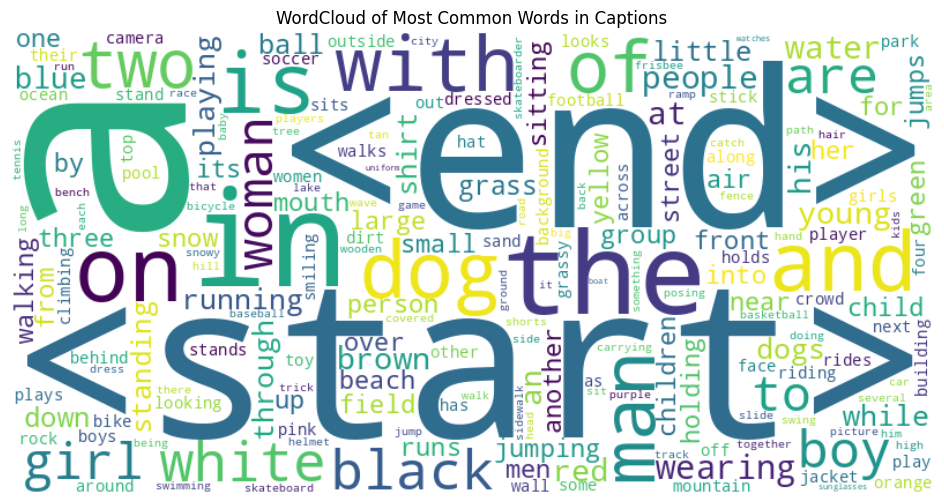

In [41]:
# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tokenizer_top_words_count)

# Display the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Most Common Words in Captions")
plt.show()

### Pad Sequences to Max Length

In [42]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
# Find maximum caption length
max_length = max(len(seq) for seq in sequences)

print("The maximum caption length of Caption vector is:", max_length)
# Pad each vector to the max_length of the captions & store it to a variable
cap_vector = pad_sequences(sequences, maxlen=max_length, padding='post')

print("The shape of Caption vector is:", cap_vector.shape)


The maximum caption length of Caption vector is: 37
The shape of Caption vector is: (40455, 37)


In [43]:
cap_vector[:5]

array([[   3,    2,   43,    5,    2,   91,  170,    8,  120,   54,    2,
         395,   13,  392,    5,   29,    1,  693,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   3,    2,   20,  314,   65,    2,  194,  118,    4,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   3,    2,   41,   20,  120,   65,    2,  194, 2424,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   3,    2,   41,   20,  120,    6,  392,   21,   61, 2424,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,

* Uses default padding behavior (0 by default)
* This preprocessing ensures clean, structured, and efficient data for the CNN-RNN Image Captioning Model.

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [44]:
#write your code here to create the dataset consisting of image paths
img_data = tf.data.Dataset.from_tensor_slices(all_img_vector)

In [45]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    # - read image
    # - resize - 299 X 299
    # - preprocess_input
    # Read image file
    img = tf.io.read_file(image_path)

    # Decode image to tensor
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize to (299, 299) for InceptionV3
    img = tf.image.resize(img, (299, 299))

    # Normalize image to [-1,1] (required for InceptionV3)
    img = preprocess_input(img)
    return img, img_path

#### Test the image

Shape before resize: Width: 500, Height: 353
Shape after resize : (299, 299, 3)


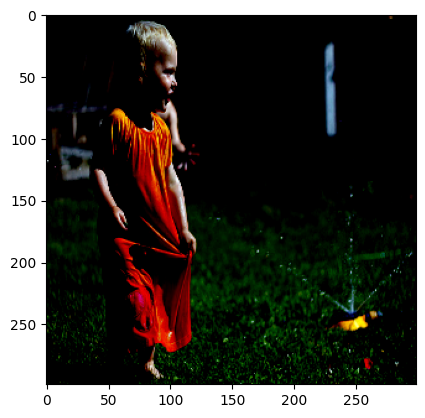

In [46]:
test_image = "/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/3767841911_6678052eb6.jpg"
img = Image.open(test_image)
width, height = img.size
print(f"Shape before resize: Width: {width}, Height: {height}")

img1, img1_path = load_image(test_image)
print("Shape after resize :", img1.shape)
plt.imshow(img1)

#### Transformed Tensor dataset

In [47]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
# Create dataset from image paths
img_data = tf.data.Dataset.from_tensor_slices(all_img_vector)

# Apply preprocessing function with parallel execution
img_data = img_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch dataset efficiently (optimized for T4 GPU)
img_data = img_data.batch(64, drop_remainder=False)

In [48]:
img_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [49]:
all_img_vector[:5]

['/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/1000268201_693b08cb0e.jpg']

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [50]:
image_model = InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

# The final model to extract features
image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [51]:
# write your code to extract features from each image in the dataset
image_features_extract_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 32) │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 32) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 32) │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 32) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 64) │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None, 64) │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None, 64) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 64) │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 80) │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None, 80) │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None, 80) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │        138,240 │ activation_3[0][0]     │
│                           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, None,     │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [52]:
# Function to load and preprocess an image
def extract_image_features(image_path, image_counter):
    # Load image
    img = image.load_img(image_path, target_size=(299, 299))  # Resize to (299, 299)
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for InceptionV3

    # Extract features using the InceptionV3 model
    features = image_features_extract_model.predict(img_array)
    # Check the shape of features to confirm dimensions
    print(f"{image_counter} Feature shape before reshape: {features.shape}")  # Should print (1, 8, 8, 2048)

    # Reshape the features (8*8, 2048) as required
    features = features.reshape((features.shape[1]*features.shape[2], features.shape[3]))  # Shape: (8*8, 2048)
    return features

We can store these extracted features either in a dictionary or as .npy files. Using .npy is recommended for efficiency since we don't have to extract features again and again

In [53]:
len(all_img_vector)

40455

## Feature Extraction, Save / Load Image features from 'image_features.npy

In [54]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
# Store extracted features for all images
# Check if the 'image_features.npy' file exists

image_features_dict = {}
image_counter = 0
feature_file = "/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/image_features.npy"
if os.path.exists(feature_file):
    try:
        # Try to load the saved image features from the file
        image_features_dict = np.load(feature_file, allow_pickle=True).item()
        print("Image features loaded successfully from 'image_features.npy'.")
    except FileNotFoundError:
        print("'image_features.npy' not found, proceeding with feature extraction.")
        # Extract features for each image if the file is not found or loading fails
        for img_path in all_img_vector:
          image_counter = image_counter+1
          print(f"extracting features for {image_counter}: {img_path}")
          image_features_dict[img_path] = extract_image_features(img_path, image_counter)
        # Save the extracted features to 'image_features.npy' for future use
        np.save(feature_file, image_features_dict)
        print("Image features extracted and saved successfully.")
else:
    print("'image_features.npy' file not found, proceeding with feature extraction.")
    # Extract features for each image
    for img_path in all_img_vector:
      image_counter = image_counter+1
      print(f"extracting features for {image_counter}: {img_path}")
      image_features_dict[img_path] = extract_image_features(img_path, image_counter)
    # Save the extracted features to 'image_features.npy'
    np.save(feature_file, image_features_dict)
    print("Image features extracted and saved successfully.")



Image features loaded successfully from 'image_features.npy'.


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [55]:
len(image_features_dict)

8091

In [56]:
import more_itertools
top_5_items = more_itertools.take(5, image_features_dict.items())

top_5_items #printing first 5 elememts have dictionary

[('/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.13762335],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.10225638],
         [0.        , 0.        , 0.8232216 , ..., 0.        , 0.        ,
          0.04508057],
         ...,
         [0.        , 0.        , 2.3677666 , ..., 0.04099649, 0.        ,
          1.5961043 ],
         [0.        , 0.        , 1.1409979 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.2765861 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/flickr8k/images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.97476363, 0.06330245, ..., 0.        , 0.        ,
          3.4940777 ],
         [0.        , 1.6327231 , 0.  

In [57]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80-20 split)
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector, test_size=0.2, random_state=42)


In [58]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [59]:
# Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

# Update the map_func to handle decoding within TensorFlow operations
def map_func(img_path, caption):
    # Decode the image path tensor using tf.strings.as_string
    img_path_str = tf.strings.as_string(img_path)

    # Extract the feature using the decoded image path
    img_tensor = tf.py_function(lambda path: image_features_dict[path.numpy().decode('utf-8')], [img_path_str], tf.float32)

    # Return the features and the caption
    return img_tensor, caption


### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [60]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image_paths, captions, batch_size=64):
    # Create dataset from image paths and captions
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, captions))

    # Apply the mapping function to extract features and captions
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle, batch, and prefetch the dataset
    dataset = dataset.shuffle(buffer_size=len(image_paths))  # Shuffle the training data
    dataset = dataset.batch(batch_size, drop_remainder=False)  # Batch the data
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch for faster loading

    return dataset

Now, Let's create the train and test datasets by applying the gen_dataset() function to path_train, cap_train, path_test, and cap_test

In [61]:
train_dataset = gen_dataset(path_train, cap_train)
test_dataset = gen_dataset(path_test, cap_test)

In [62]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 37)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [63]:
# path_train, path_test, cap_train, cap_test
BATCH_SIZE = 64
embedding_dim = 256
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [92]:
@register_keras_serializable()
class Encoder(Model):
    def __init__(self, embed_dim):
        super(Encoder, self).__init__()
        # A dense layer to transform image features to the embedding dimension
        self.dense = layers.Dense(embed_dim, activation='relu')

    def call(self, features):
        # features shape: (batch_size, 8*8, embedding_dim)
        # Apply dense layer (which already has ReLU activation)
        features = self.dense(features)  # Apply dense layer to features
        return features


In [93]:
encoder=Encoder(embedding_dim)

### Attention model

In [94]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        # Dense layers for computing attention score
        self.W1 = layers.Dense(units)  # For the hidden state
        self.W2 = layers.Dense(units)  # For the features
        self.V = layers.Dense(1)  # For the attention weights

        self.units = units

    def call(self, features, hidden):
        # Expand hidden state to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # Compute attention scores (shape: (batch_size, 8*8, units))
        score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis) + self.W2(features)))

        # Attention weights shape: (batch_size, 8*8, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Compute the context vector: (batch_size, 8*8, embedding_dim)
        context_vector = attention_weights * features

        # Reduce to shape: (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Decoder

In [95]:
@register_keras_serializable()
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units

        # Attention model
        self.attention = Attention_model(units)

        # Embedding layer for input tokens
        self.embed = layers.Embedding(vocab_size, embed_dim)

        # GRU for sequence modeling
        self.gru = layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

        # Dense layers for generating predictions
        self.d1 = layers.Dense(self.units, activation='relu')
        self.d2 = layers.Dense(vocab_size)

    def call(self, x, features, hidden):
          # Ensure hidden has batch dimension (batch_size, hidden_size)
        if len(hidden.shape) == 1:  # If shape is (units,)
          hidden = tf.expand_dims(hidden, 0)  # Convert to (1, units)

        # Get context vector and attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)

        # Embed the input token: (batch_size, 1, embedding_dim)
        embed = self.embed(x)

        # Concatenate the context vector and the input token embedding
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)

        # Pass through GRU (returning both output and hidden state)
        # Extract only the first two outputs (output and final hidden state)
        output = self.gru(embed, initial_state=hidden)

        gru_output, hidden_state = output[:2]

        # Debugging: Check the shapes of the returned values
        #print(f"GRU output shape: {gru_output.shape}")
        #print(f"Hidden state shape: {hidden_state.shape}")

        # Debugging: Print the output of GRU
        # print(f"GRU output: {output}")

        # If we expect two values, let's check how they are being returned
        # if isinstance(output, tuple):
        #     print(f"Number of values returned by GRU: {len(output)}")
        #     for i, o in enumerate(output):
        #         print(f"Output {i} shape: {o.shape}")

        # Apply Dense layers to output
        output = self.d1(gru_output)
        # L4 GPU returns 65 outputs, which could be an indication of how CuDNN handles
        # multiple hidden layers or time steps differently.
        # Reshape for prediction: (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # Output prediction: (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output, hidden_state, attention_weights

    def init_state(self, batch_size):
      return tf.zeros((batch_size, self.units))

    def reset_state(self, batch_size):
      return tf.zeros((batch_size, self.units))  # Reset hidden state


note:  it's good to be aware that TensorFlow can return different GRU outputs depending on the hardware, especially on optimized GPUs like L4.

On CPU, TensorFlow’s GRU typically returns:

`output, state = self.gru(embed, initial_state=hidden)`

On GPU (CuDNN), the same call might return multiple outputs:

`output, state_1, state_2, ..., state_n = self.gru(embed, initial_state=hidden)`

* In my case showed 65 outputs, which could be an indication of
how CuDNN handles multiple hidden layers or time steps differently.
* TensorFlow automatically switches to the CuDNN-optimized implementation of GRU when running on an NVIDIA GPU (like the L4 in Colab).

In [96]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [97]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


In [70]:
import tensorflow as tf
print(tf.__version__)


2.18.0


The TensorFlow version pre-installed on Colab may have subtle differences in how it runs RNN layers compared to local installations. Since I'm on TensorFlow 2.17.1, it likely includes optimizations specific to NVIDIA GPUs (L4, A100, T4, etc.).

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

### Load training models if already saved

In [98]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

### Define Optimzer & Loss Object

In [102]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')  # Define your loss object


### Define Loss Function

In [103]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Set Checkpoint Path

In [104]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/01. Assignments/7. Capstone Project/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

### Configure to Load / Save training checkpoints

Lets add the ability to save and load the training check points  before starting training.

In [105]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(f"Restored from checkpoint at epoch {start_epoch}")
else:
    print("Initializing training from scratch")

Restored from checkpoint at epoch 13


* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [106]:
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)

    avg_loss = (loss / int(target.shape[1]))

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

### Test Step (Using Previous Prediction)

In [107]:
def test_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, t], 1)

    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))

    return loss, avg_loss

### Compute Test Loss Over Dataset

In [108]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps

    return avg_test_loss

### Training Loop

In [109]:
loss_plot = []
test_loss_plot = []
EPOCHS = 13

best_test_loss = 100

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0
    train_num_steps = len(train_dataset)

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss = total_loss / train_num_steps

    loss_plot.append(avg_train_loss)

    # Compute test loss
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print(f"For epoch: {epoch+1}, Train Loss: {avg_train_loss:.3f}, Test Loss: {test_loss:.3f}")
    print(f"Time taken for 1 epoch {time.time() - start:.2f} sec\n")

    # Save checkpoint if test loss improves
    if test_loss < best_test_loss:
        print(f"Test loss reduced from {best_test_loss:.3f} to {test_loss:.3f}. Saving checkpoint...")
        best_test_loss = test_loss
        ckpt_manager.save()


0it [00:00, ?it/s]


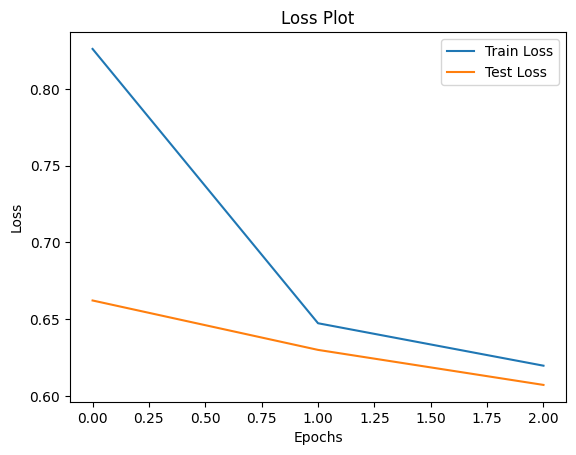

In [92]:
plt.plot(loss_plot, label="Train Loss")
plt.plot(test_loss_plot, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

## Save the model for future loading

In [110]:
encoder.save(model_save_path + "/encoder.keras")
decoder.save(model_save_path + "/decoder.keras")
print("Model saved successfully.")

Model saved successfully.


#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

The greedy search algorithm predicts the next word by choosing the word with the highest probability at each time step, using the decoder's output.

In [142]:
IMAGE_SHAPE= (299, 299)

def preprocess_images_function(image_path):

    img = tf.io.read_file(image_path,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.decode_jpeg(img,channels=0)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path

In [147]:
def evaluate(image, encoder, decoder, tokenizer, image_counter, max_length=30):
    # Initialize attention plot, decoder hidden state, and input preprocessing
    attention_plot = np.zeros((max_length, 8, 8))  # Assuming attention map size 8x8
    hidden = decoder.reset_state(batch_size=1)  # Reset the hidden state of the decoder

    # Process input image and extract features
    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0)  # Preprocess image
    img_tensor_val = image_features_extract_model(temp_input)  # Extract features using feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))  # Flatten feature map

    features = encoder(img_tensor_val)  # Get features from encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)  # Start token for decoder
    result = []

    # Generate caption using greedy search
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)  # Decoder output

        # Ensure that attention_weights can be reshaped into (8, 8)
        if len(attention_weights.shape) > 2:
            attention_weights = tf.reduce_sum(attention_weights, axis=-1)  # Sum over the last axis (if 3D)
        attention_weights = tf.reshape(attention_weights, (8, 8))  # Reshape to match attention plot size
        attention_plot[i] = attention_weights.numpy()  # Store attention weights

        predicted_id = tf.argmax(predictions[0]).numpy()  # Choose word with max probability
        word = tokenizer.index_word[predicted_id]  # Get the word corresponding to the ID
        result.append(word)

        # Stop if <end> token is predicted
        if word == '<end>':
            break

        dec_input = tf.expand_dims([predicted_id], 0)  # Prepare input for next time step

    attention_plot = attention_plot[:len(result), :]  # Trim the attention plot to match the result length
    return result, attention_plot, predictions

### Beam Search(optional)

In [172]:
def beam_evaluate(image, encoder, decoder, tokenizer, beam_index=3, max_length=30):
    # Initialize beam search variables
    hidden = decoder.reset_state(batch_size=beam_index)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * beam_index, 0)

    sequences = [[list(), 1.0]] * beam_index  # Store sequences and their probabilities
    all_predictions = []

    for i in range(max_length):
        all_candidates = list()
        for seq, score in sequences:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            # Get top 'beam_index' predictions for each sequence
            top_k_predictions = tf.nn.top_k(predictions[0], k=beam_index)
            top_k_ids = top_k_predictions.indices.numpy()

            for idx in range(beam_index):
                candidate = list(seq)  # Copy sequence
                candidate.append(tokenizer.index_word[top_k_ids[idx]])  # Add predicted word
                all_candidates.append((candidate, score * top_k_predictions.values[idx].numpy()))  # Update score

        # Sort all candidates based on score and select top 'beam_index' sequences
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_index]

        dec_input = tf.expand_dims([seq[0][-1] for seq in sequences], 0)  # Use last predicted word for next step

    # Choose the best sequence from beam search
    final_caption = ' '.join(sequences[0][0])  # The best sequence based on highest score
    return final_caption


In [168]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(PILImage.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(PILImage.fromarray(weights_img).resize((224, 224), PILImage.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [137]:
from nltk.translate.bleu_score import sentence_bleu

In [138]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

### Generate Caption and Audio function

In [169]:
from PIL import Image as PILImage
def generate_caption_and_audio(img_test, cap_test, tokenizer, encoder, decoder, weights=(0.5, 0.5), max_length=30):
    """
    Generate captions for a random image, compute BLEU score, plot attention map, and generate audio for the caption.

    Parameters:
        img_test (list): List of test images.
        cap_test (list): List of corresponding captions.
        tokenizer (Tokenizer): The tokenizer for word-to-index mapping.
        encoder (Model): The trained encoder model.
        decoder (Model): The trained decoder model.
        weights (tuple): BLEU score weights for n-gram evaluation.
        max_length (int): Maximum caption length.

    Returns:
        str: The predicted caption.
    """
    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]

    # Real caption from the dataset
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])

    # Evaluate the generated caption using greedy search
    result, attention_plot, pred_test = evaluate(test_image, encoder, decoder, tokenizer, image_counter=rid, max_length=max_length)

    # Clean the real caption and predicted caption
    real_caption = filt_text(real_caption)
    pred_caption = ' '.join(result).rsplit(' ', 1)[0]  # Remove <end> token if present

    # Compute BLEU score
    real_appn = [real_caption.split()]
    candidate = pred_caption.split()
    score = sentence_bleu(real_appn, candidate, weights=weights)
    print(f"BLEU score: {score * 100:.2f}%")

    # Print real and predicted captions
    print(f"Real Caption: {real_caption}")
    print(f"Predicted Caption: {pred_caption}")

    # Plot attention map
    plot_attmap(result, attention_plot, test_image)

    # Generate and play audio for the predicted caption using Google Text to Speech
    speech = gTTS("Predicted Caption is: " + pred_caption, lang='en', slow=False)
    audio_file = 'voice.mp3'
    speech.save(audio_file)  # Save speech to file

    # Display the audio (audio player in the notebook)
    display(Audio(audio_file, rate=None, autoplay=False))

    # Display the image in the notebook
    display(Image(filename=test_image))  # Display image in the notebook

    return pred_caption

In [149]:
len(path_test)
img_test=path_test.copy()

### Verify calls with different weights using Greedy Search

Evaluating with weights: (1, 0)
BLEU score: 54.55%
Real Caption: a race car is observed by the crowd
Predicted Caption: a silver and white car is observed by a red race


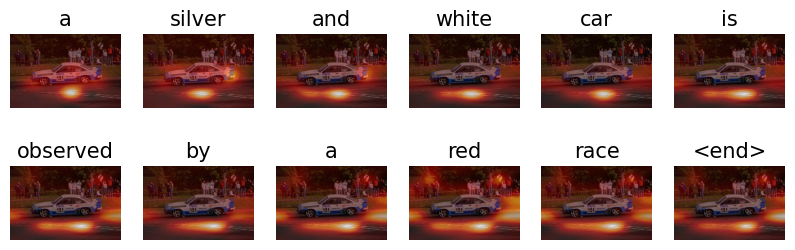

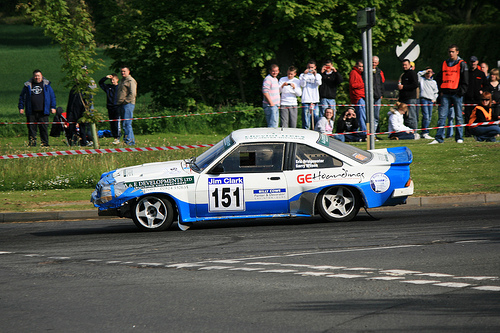

Predicted Caption: a silver and white car is observed by a red race


In [170]:
# Test calling function once with a sample score weights
weights_list = [(1, 0)]  # Example weights for unigram and bigram

for weight in weights_list:
    print(f"Evaluating with weights: {weight}")
    predicted_caption = generate_caption_and_audio(img_test, cap_test, tokenizer, encoder, decoder, weights=weight)
    print(f"Predicted Caption: {predicted_caption}")

Evaluating with weights: (1, 0)
BLEU score: 69.60%
Real Caption: two black dogs are playing tugofwar with an orange toy
Predicted Caption: two black dogs are playing with a stuffed toy


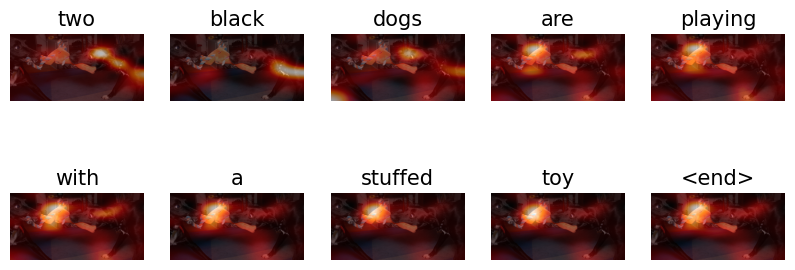

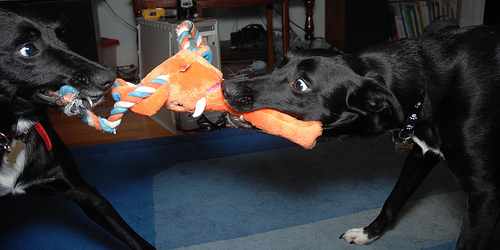

Predicted Caption: two black dogs are playing with a stuffed toy
Evaluating with weights: (0.5, 0.5)
BLEU score: 26.73%
Real Caption: a boy stands near a structure outside
Predicted Caption: a boy is standing on a gap


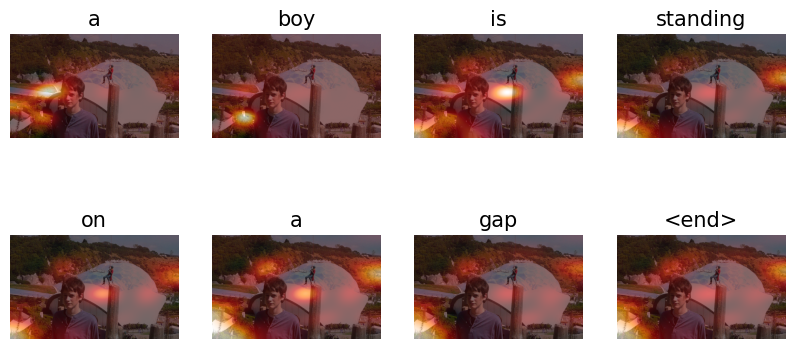

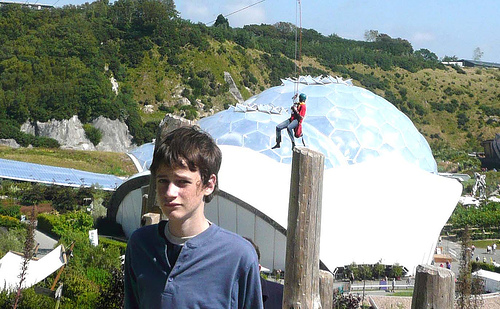

Predicted Caption: a boy is standing on a gap
Evaluating with weights: (0, 1)
BLEU score: 50.00%
Real Caption: a german shepherd is running with a stick in its mouth
Predicted Caption: a dog runs through water with a stick in its mouth


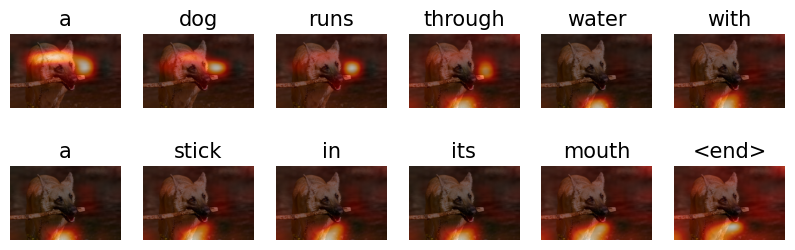

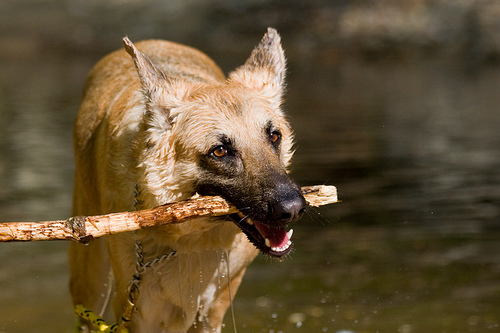

Predicted Caption: a dog runs through water with a stick in its mouth


In [173]:
# Calling function multiple times with different BLEU score weights
weights_list = [(1, 0), (0.5, 0.5), (0, 1)]  # Example weights for unigram and bigram

for weight in weights_list:
    print(f"Evaluating with weights: {weight}")
    predicted_caption = generate_caption_and_audio(img_test, cap_test, tokenizer, encoder, decoder, weights=weight)
    print(f"Predicted Caption: {predicted_caption}")

## Summary

* We have implemented a preprocessing pipeline for images, converting them into a format suitable for deep learning models.
* The feature extraction from images is done using the InceptionV3 model (a pre-trained convolutional neural network for image classification). We extract high-level image features which are later used by the caption generation model.
* I have used a combination of an encoder and decoder model. The encoder extracts relevant features from the image, and the decoder generates captions word by word, attending to different parts of the image at each time step.
* Encoder: We use the InceptionV3 model to extract image features, which are processed further by a custom encoder to generate high-level features that can be used in sequence generation.
* Decoder: The decoder which uses GRU and attention mechanisms to focus on parts of the image that are more relevant to the caption being generated.
* The decoder employs a GRU (Gated Recurrent Unit), a type of recurrent neural network, to model the sequential generation of words. The GRU in the decoder processes the context from the encoder and updates its hidden state at each time step to generate the next word in the caption.
* Image features are extracted by applying image_features_extract_model to the processed images, which are reshaped and passed to the encoder model for further processing.
* Attention mechanism allows the model to focus on different parts of the image as it generates each word in the caption. This is reflected in an attention plot that shows the areas of focus during each step.
* Attention weights are stored for each word in the generated caption to visualize the regions of the image the model is paying attention to at each word generation step.
* Caption Generation using Greedy Search: Using greedy search algorithm for caption generation, the model selects the word with the highest probability at each step, iteratively building a caption until the <end> token is predicted or the maximum length is reached.
* The BLEU score is computed to evaluate the quality of the generated caption against the ground truth caption. This metric is used to assess how closely the predicted caption matches the real caption.
* Once the caption is generated, I have used the Google Text-to-Speech (gTTS) to convert the caption into an audio file and plays it back, enhancing the interactivity of the system.
* The system is capable of displaying the image along with the attention map, showing the regions the model focused on during caption generation, the original test image and the audio file
